In [75]:
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import networkx.algorithms.isomorphism as iso
from tqdm import tqdm
from joblib import Parallel, delayed

In [76]:
from utils import *
from preprocessing import Dataset

In [5]:
with gzip.open('data.pickle.gz', 'rb') as fh:
    data = pickle.load(fh, )

In [6]:
dataset = Dataset(data)

In [7]:
dataset.data.subgroup.value_counts()

S6_diff    715
V6_diff    715
S6_same    700
V6_same    700
V3_diff    379
S3_diff    379
S5_diff    379
V5_diff    379
V3_same    364
S5_same    364
S3_same    364
V5_same    364
V2          15
S4          15
X5_diff     15
S2          15
V4          15
X5_same     14
X2_diff     10
X4_diff     10
X2_same      9
X4_same      9
S1           1
V1           1
X3           1
X1           1
Name: subgroup, dtype: int64

In [90]:
class MatrixBuilder:
    def __init__(self, dataset, name):
        self.group_df = dataset[name].copy()
        self.group_df['distance_graph'] = self.group_df.defect_representation.apply(
            lambda x: nx.from_numpy_matrix(x.distance_matrix)
        ) 
        finder = SpacegroupAnalyzer(dataset.get_full_structure(),
                                    symprec=1e-1)
        self.checker = finder.get_space_group_operations()
    
    def get_nn(self, structure, site, atol=1e-1):
        """
        returns indicies of neighbouring sites in structure for given site.
        """
        layer_coords = build_layers_coords(structure)
        layer = get_layer(site, layer_coords)
        nearest_neighbor_ids = []
        dx, dy = get_x_y_dist(structure)
        for i,s in enumerate(structure):
            if max(np.isclose(site.distance(s), [dx, dy], atol=atol)) == 1 and get_layer(s, layer_coords) == layer:
                nearest_neighbor_ids.append(i)    
        return nearest_neighbor_ids
    
    def swap_sites(self, structure, defect_site, idx):
        """
        Swap defect site with site in structure by index.
        Works correctly when defect is substitution or vacancy
        """
        defect_species = defect_site.species_string
        site_species = structure[idx].species_string
        if defect_species == site_species:
            return structure.copy(), defect_site
        new_defect_site = PeriodicSite(defect_site.species, 
                                       structure[idx].frac_coords, 
                                       structure[idx].lattice)
        if defect_species != "X0+":
            defect_idx = find_site(structure, defect_site)
            indices_species_map = {idx: defect_species, 
                                   defect_idx: site_species}
            transformation = ReplaceSiteSpeciesTransformation(indices_species_map)
            return transformation.apply_transformation(structure), new_defect_site
        insert_transf = InsertSitesTransformation([site_species],
                                                  [defect_site.frac_coords])
        remove_transf = RemoveSitesTransformation([idx])
        removed_s = remove_transf.apply_transformation(structure)
        return insert_transf.apply_transformation(removed_s), new_defect_site
    
    
    def generate_neighbouring_structures(self, structure, defects, how=None):
        """
        Only one swap.
        """
        def defects_are_eq(d1, d2):
            if how is None:
                return self.checker.are_symmetrically_equivalent(d1, 
                                                            d2, 
                                                            symm_prec=0.01)
            elif how == "DG":
                return matrices_are_isomofic(d1.distance_matrix, 
                                             d2.distance_matrix)
            raise ValueError(f"Undefined comparison style: {how}")
            
        result_structures = []
        defect_reprs = []
        for i, defect_site in enumerate(defects):
            nns = self.get_nn(structure, defect_site)
            for n_idx in nns:
                new_structure, new_defect_site = self.swap_sites(structure, 
                                                            defect_site, 
                                                            n_idx)
                new_defect_repr = defects.copy()
                new_defect_repr[i] = new_defect_site

                # check if swapped with another defect
                found, idx = safe_find_site(defects, new_defect_site)
                if found:
                    swapped_defect_site = PeriodicSite(defects[idx].species, 
                                       defect_site.frac_coords, 
                                       defect_site.lattice)
                    new_defect_repr[idx] = swapped_defect_site
                # check if got something different from 
                # initial conf and all generated before
                is_new = True
#                 for reprn in defect_reprs+[defects]:
                for reprn in defect_reprs:
                    if self.checker.are_symmetrically_equivalent(reprn, new_defect_repr, symm_prec=0.01):
                        is_new = False
                        break
                if is_new or len(defect_reprs) == 0:
                    result_structures.append(new_structure)
                    defect_reprs.append(new_defect_repr)
        return result_structures, defect_reprs
    
    def get_similar_by_dg(self, defect_representation, rtol=1e-2):
        G = nx.from_numpy_matrix(defect_representation.distance_matrix)
        edge_comp = iso.numerical_edge_match("weight", 0.0, rtol=rtol)
        match = lambda x: nx.is_isomorphic(x, G, edge_match=edge_comp)
        return self.group_df[np.vectorize(match)(
            self.group_df.distance_graph
        )]    
    
    def get_equivalent_idx(self, defect_representation, how=None):
        if how is None:
            to_search = self.group_df
        elif how=="DG":
            to_search = self.get_similar_by_dg(defect_representation)
        if len(to_search) == 1:
            return to_search.index[0]
        for i, row in to_search.iterrows():
            if self.checker.are_symmetrically_equivalent(defect_representation,
                                                    row.defect_representation,
                                                    symm_prec=0.01):
                return i
        raise ValueError(
            f"Not found symmetrically equivalent structure for {defect_representation}"
        )
        
    def _generate_delta_e_dict(self, how=None, n_jobs=1):
        """
        Returns dict with E_dst-E_src (energies of destination and source conf)
        """
        def get_item(i, row):
            adj_dict = {}
            cur_energy = row.energy_per_atom
            ns, defect_reprs = self.generate_neighbouring_structures(
                row.initial_structure, row.defect_representation, how=how)
            adj_dict[i] = {}
            for defect_repr in defect_reprs:
                idx = self.get_equivalent_idx(defect_repr, how)
                energy = self.group_df.loc[idx].energy_per_atom
                if idx != i:
                    adj_dict[i] |= {idx: {"weight": energy - cur_energy}}
            return adj_dict

        result = Parallel(n_jobs=n_jobs, verbose=1000)(
            delayed(get_item)(i, row) for i, row in self.group_df.iterrows()
        )
        adj_dict = {}
        for entry in result:
            adj_dict |= entry
        return adj_dict
        
        
    def generate_group_adj_dict(self, thr=0.0, n_jobs=1, how=None):
        """
        Parallel
        """
        def get_item(i, row):
            adj_dict = {}
            cur_energy = row.energy_per_atom
            ns, defect_reprs = self.generate_neighbouring_structures(
                row.initial_structure, row.defect_representation, how=how)
            adj_dict[i] = []
            for defect_repr in defect_reprs:
                idx = self.get_equivalent_idx(defect_repr, how)
                energy = self.group_df.loc[idx].energy_per_atom
                if energy - cur_energy <= thr:
                    adj_dict[i].append(idx)
            return adj_dict

        result = Parallel(n_jobs=n_jobs, verbose=1000)(
            delayed(get_item)(i, row) for i, row in self.group_df.iterrows()
        )
        adj_dict = {}
        for entry in result:
            adj_dict |= entry
        return adj_dict

In [91]:
X2_MB = MatrixBuilder(dataset, 'V5_diff')

In [40]:
X2_MB.group_df.index[0]

1

In [92]:
%time ad = X2_MB.generate_group_adj_dict(how="DG", n_jobs=-3)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-3)]: Done  11 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-3)]: Done  14 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-3)]: Done  15 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-3)]: Done  16 tasks      | elapsed:   36.7s
[Paralle

[Parallel(n_jobs=-3)]: Done 134 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-3)]: Done 135 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-3)]: Done 136 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-3)]: Done 137 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-3)]: Done 138 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-3)]: Done 139 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-3)]: Done 140 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-3)]: Done 141 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-3)]: Done 142 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-3)]: Done 143 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-3)]: Done 144 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-3)]: Done 145 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-3)]: Done 146 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 147 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 148 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 149 tasks      | elapsed:  4.9min
[Paralle

[Parallel(n_jobs=-3)]: Done 267 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-3)]: Done 268 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-3)]: Done 269 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-3)]: Done 270 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-3)]: Done 271 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-3)]: Done 272 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-3)]: Done 273 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-3)]: Done 274 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-3)]: Done 275 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-3)]: Done 276 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-3)]: Done 277 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-3)]: Done 278 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-3)]: Done 279 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-3)]: Done 280 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-3)]: Done 281 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-3)]: Done 282 tasks      | elapsed:  9.0min
[Paralle

In [63]:
ad

{24: [2917, 2686, 3529, 4944],
 41: [1764, 41, 1265, 24, 167, 3529, 2686, 695],
 69: [1790,
  221,
  1646,
  3524,
  2445,
  158,
  2921,
  1349,
  2725,
  530,
  1518,
  3269,
  2074,
  3438,
  2287],
 81: [2848,
  3516,
  1042,
  3802,
  4333,
  2311,
  2859,
  4343,
  288,
  1070,
  2597,
  1868,
  5210],
 91: [2749, 4415, 2464, 888, 4650, 601, 2547, 2477, 1313],
 104: [2091, 1058, 676, 3282, 4282],
 120: [976, 2341, 676, 132, 410, 1490, 405, 1167],
 132: [2485, 405, 132, 976, 1873, 4163, 410],
 150: [2457, 3977, 150, 2528, 1058, 3006, 456, 1094],
 158: [1381, 3438, 3576, 543, 1345, 2161, 2994, 4450, 69, 2725, 4239],
 167: [695, 3529, 4102, 167, 4104, 4064, 2686],
 189: [586, 1884, 405, 1873, 2794, 2621, 189, 4159],
 195: [195, 2992, 1740, 2682, 2202, 2254, 4346, 2701],
 199: [4532, 4206, 2099, 1495],
 221: [2542, 1790, 3660, 1588, 2161, 4720, 2287, 1973, 1182, 2714],
 233: [3237, 1021, 1147, 4650, 4498, 2818, 2464, 1054],
 241: [2445,
  3524,
  281,
  2910,
  2848,
  2602,
  4630,


In [72]:
graphs = dataset.data.defect_representation.apply(
    lambda x: nx.from_numpy_matrix(x.distance_matrix)
)
graphs[24]

In [72]:
!pip install deepdiff

     |████████████████████████████████| 69 kB 2.2 MB/s eta 0:00:011


In [93]:
import deepdiff
diff = deepdiff.DeepDiff(ad, sample_V5_diff_ad, 
                         ignore_numeric_type_changes=True, ignore_order=True)
diff

{}

In [87]:
diff

{'iterable_item_added': {"root['number:554.000000000000'][12]": 3329,
  "root['number:575.000000000000'][4]": 726,
  "root['number:750.000000000000'][7]": 288,
  "root['number:771.000000000000'][5]": 1274,
  "root['number:1063.000000000000'][6]": 1387,
  "root['number:1063.000000000000'][12]": 1354,
  "root['number:1076.000000000000'][3]": 1115,
  "root['number:1209.000000000000'][14]": 1349,
  "root['number:1441.000000000000'][5]": 199,
  "root['number:1473.000000000000'][2]": 2818,
  "root['number:1518.000000000000'][3]": 2311,
  "root['number:1540.000000000000'][2]": 199,
  "root['number:1612.000000000000'][14]": 3567,
  "root['number:1660.000000000000'][3]": 2898,
  "root['number:1825.000000000000'][7]": 1335,
  "root['number:1864.000000000000'][3]": 2898,
  "root['number:1864.000000000000'][5]": 1274,
  "root['number:2066.000000000000'][3]": 726,
  "root['number:2074.000000000000'][8]": 1322,
  "root['number:2208.000000000000'][4]": 1115,
  "root['number:2464.000000000000'][3]": 4

In [88]:
ad[554]

[818, 776, 3837, 2597, 1115, 3017, 1660, 2362, 1322, 884, 4333, 3077]

In [89]:
sample_V5_diff_ad[554]

[818, 776, 3837, 2597, 1115, 3017, 1660, 2362, 1322, 884, 4333, 3077, 3329]

In [77]:
sample_V5_diff_ad = restore_adj_dict('../../Downloads/V5_diff')

In [78]:
sample_V5_diff_ad == ad

False

In [41]:

def matrices_are_isomofic(m1, m2):
    if m1.shape != m2.shape:
        return False
    G1 = nx.from_numpy_matrix(m1)
    G2 = nx.from_numpy_matrix(m2)
    edge_comp = iso.numerical_edge_match("weight", 0.0, rtol=1e-2)
    return nx.is_isomorphic(G1, G2, edge_match=edge_comp)

In [68]:
ad

{1: [],
 4: [4, 292, 208, 453],
 17: [230, 137, 165],
 45: [672, 769, 230, 17],
 137: [137, 230],
 165: [137],
 208: [208, 1, 582],
 230: [230, 769],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 551: [551, 137],
 566: [230, 137, 551],
 582: [1],
 597: [],
 672: [672],
 769: [672]}

In [18]:
def check_reachable(adj_dict, min_idx):
    is_reachable = True
    digraph = nx.from_dict_of_lists(adj_dict, create_using=nx.DiGraph)
    for node in digraph:
        if not nx.has_path(digraph, node, min_idx):
            print(f"No path from {node} to {min_idx}!")
            is_reachable = False
    return is_reachable

In [16]:
from pymatgen.core.structure import Molecule, Element
from pymatgen.io.babel import BabelMolAdaptor

In [15]:
def check_all_groups(groups, data, checker):
    all_adjs = {}
    all_reachability = {}
    for group in tqdm(groups):
        group_df = data[data.group == group]
        all_adjs[group] = generate_group_adj_dict(group_df, checker)
        min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
        all_reachability[group] = check_reachable(all_adjs[group], 
                                                     min_idx)
    return all_adjs, all_reachability

In [50]:
%time ad = generate_group_adj_dict(dataset['X2'], checker)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-3)]: Done   9 out of  19 | elapsed:    8.5s remaining:    9.4s
[Parallel(n_jobs=-3)]: Done  10 out of  19 | elapsed:    9.2s remaining:    8.3s
[Parallel(n_jobs=-3)]: Done  11 out of  19 | elapsed:    9.9s remaining:    7.2s
[Parallel(n_jobs=-3)]: Done  12 out of  19 | elapsed:   10.4s remaining:    6.1s
[Parallel(n_jobs=-3)]: Done  13 out of  19 | elapsed:   10.6s remaining:    4.9s
[Parallel(n_jobs=-3)]: 

In [51]:
ad

{1: [],
 4: [4, 292, 208, 453],
 17: [230, 137, 165],
 45: [672, 769, 230, 17],
 137: [137, 230],
 165: [137],
 208: [208, 1, 582],
 230: [230, 769],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 551: [551, 137],
 566: [230, 137, 551],
 582: [1],
 597: [],
 672: [672],
 769: [672]}

In [46]:
dataset['X2_diff'].loc[4]

energy_per_atom                                                  -7.287014
initial_structure        [[1.27612629e-07 1.84192955e+00 3.71975100e+00...
defect_representation    [[ 7.96302799 17.50569919  2.15745558] X0+, [-...
subgroup                                                           X2_diff
group                                                                   X2
Name: 4, dtype: object

In [17]:
from openbabel import openbabel, pybel

In [18]:
dataset[24].defect_representation

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: X0+ (3.2031, 7.3604, 3.7198) [0.2920, 0.3330, 0.2500]
PeriodicSite: Se (23.9274, 0.9210, 2.1549) [0.9583, 0.0417, 0.1448]
PeriodicSite: Se (1.5952, 0.9210, 5.2846) [0.0833, 0.0417, 0.3552]

In [19]:
def create_pbmol(defect_representation):
    mol = openbabel.OBMol()
    n = len(defect_representation)
    for defect in defect_representation:
        a = mol.NewAtom()
        coords = defect.coords
        atomic_num = defect.specie.Z
        if defect.specie.symbol == 'X':
            atomic_num = 0
        a.SetAtomicNum(atomic_num)
        a.SetVector(*coords)
    for i in range(n):
        for j in range(i+1, n, 1):
            mol.AddBond(i+1, j+1, 1)
    return pybel.Molecule(mol)
        

In [20]:
def get_fp(defect_representation, fptype='ecfp8'):
    return create_pbmol(defect_representation).calcfp(fptype=fptype)

In [21]:
dataset.data['ecfp8'] = dataset.data.defect_representation.apply(get_fp)

In [22]:
dataset[0].ecfp8 | dataset[1].ecfp8

0.0

In [29]:
%time structs, defects = generate_neighbouring_structures(dataset[24].initial_structure, d24, checker)

CPU times: user 11.5 s, sys: 1.69 s, total: 13.2 s
Wall time: 11 s


In [30]:
%time get_energy_idx(defects[0], dataset['V5_diff'], checker)

CPU times: user 15.8 s, sys: 96.2 ms, total: 15.9 s
Wall time: 15.8 s


(-7.215996335078534, 2917)

In [102]:
m1 = dataset[2917].defect_representation.distance_matrix

In [103]:
m2 = defects[0].distance_matrix

In [107]:
matrices_are_isomofic(m1, m2)

False

In [105]:
matrices_are_isomofic(dataset[2686].defect_representation.distance_matrix, defects[1].distance_matrix)

True

In [65]:
type(dataset[24].defect_representation.distance_matrix)

numpy.ndarray

In [123]:
def check_matr_repr(idx):
    ns, defect_reprs = generate_neighbouring_structures(
        dataset[idx].initial_structure, dataset[idx].defect_representation, checker
    )
    for defect_repr in defect_reprs:
        for i, row in dataset[dataset[idx].subgroup].iterrows():
            if checker.are_symmetrically_equivalent(defect_repr,
                                                row.defect_representation,
                                                symm_prec=0.01):
                assert matrices_are_isomofic(row.dist_matr, defect_repr.distance_matrix)
    

In [124]:
check_matr_repr(24)

In [88]:
def with_isomorfic_matr(defect_repr, m2):
    return matrices_are_isomofic(defect_repr.distance_matrix, 
                                 m2)
is24 = dataset.data[np.vectorize(matrices_are_isomofic, excluded=[1])(dataset.data.dist_matr,
                                                 dataset[24].defect_representation.distance_matrix)]

In [89]:
is24

,energy_per_atom,initial_structure,defect_representation,subgroup,group,dist_matr
idx,,,,,,
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"[[0.0, 8.181540959822657, 6.819087784854247], ..."
239,-7.282005,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.19031557 12.89350732 3.719751 ] W, [14....",S5_diff,S5,"[[0.0, 8.179869022801043, 6.823051215152787], ..."
1903,-7.289582,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,[[8.50750874e-08 7.36771851e+00 3.71975100e+00...,S6_diff,S6,"[[0.0, 6.8184941833112696, 8.179868856895947],..."
1938,-7.229946,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 12.88613968 3.719751 ] X0+, [1...",V3_diff,V3,"[[0.0, 6.814560204260533, 8.182744596837605], ..."
3574,-7.223203,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[20.74981331 4.59745635 3.719751 ] X0+, [ ...",V6_diff,V6,"[[0.0, 8.182744596837606, 6.819087784854248], ..."
4431,-7.222900,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[11.17886621 10.12324524 3.719751 ] X0+, [9...",V6_diff,V6,"[[0.0, 6.814560204260535, 8.181540909928607], ..."
4879,-7.296642,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-7.97578912 21.18219065 3.719751 ] W, [-6....",S3_diff,S3,"[[0.0, 6.812520560511897, 8.166103060233555], ..."
5872,-7.289554,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[6.38063149 7.36771851 3.719751 ] W, [1.5823...",S6_diff,S6,"[[0.0, 8.181046199364769, 6.823050976476825], ..."


In [86]:
is24.dist_matr.iloc[3]

array([[0.        , 8.19148728, 4.02859624],
       [8.19148728, 0.        , 6.3429007 ],
       [4.02859624, 6.3429007 , 0.        ]])

In [87]:
is24.dist_matr.iloc[6]

array([[0.        , 8.1827446 , 6.81908778],
       [8.1827446 , 0.        , 4.47649516],
       [6.81908778, 4.47649516, 0.        ]])

In [87]:
dataset.data['dist_matr'] = dataset.data.defect_representation.apply(
            lambda x: x.distance_matrix
        )

In [99]:
dataset.data.where(dataset.data.ecfp2 | dataset[2917].ecfp2 > 0).dropna()

,energy_per_atom,initial_structure,defect_representation,subgroup,group,ecfp2,ecfp8
idx,,,,,,,
16,-7.230149,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-1.58239659 21.17482301 3.719751 ] X0+, [ ...",V3_same,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
21,-7.230071,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 9.58370836 18.41192856 3.719751 ] X0+, [1...",V3_diff,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
27,-7.215708,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 7.36035079 3.719751 ] X0+, [ ...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
28,-7.222900,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.17755444 18.41192856 3.719751 ] X0+, [3...",V6_same,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...
5928,-7.230001,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[12.77402406 7.36035079 3.719751 ] X0+, [-...",V3_same,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5929,-7.224031,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.17755444 7.36035079 3.719751 ] X0+, [3...",V6_diff,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."
5930,-7.222300,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,[[1.27612628e-02 1.28861397e+01 3.71975100e+00...,V6_diff,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."


In [140]:
dataset[21]

energy_per_atom                                                  -7.230071
initial_structure        [[1.27612629e-07 1.84192955e+00 3.71975100e+00...
defect_representation    [[ 9.58370836 18.41192856  3.719751  ] X0+, [1...
subgroup                                                           V3_diff
group                                                                   V3
ecfp2                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
ecfp8                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
Name: 21, dtype: object

In [122]:
def same_ecfp(fp1, fp2):
    return fp1.bits == fp2.bits

In [138]:
dataset.data[np.vectorize(same_ecfp)(dataset.data.ecfp8, get_fp(defects[5]))]

,energy_per_atom,initial_structure,defect_representation,subgroup,group,ecfp2,ecfp8
idx,,,,,,,
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
27,-7.215708,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 7.36035079 3.719751 ] X0+, [ ...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
35,-7.215566,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 1.60791911 21.17482301 3.719751 ] X0+, [1...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
41,-7.215624,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 12.88613968 3.719751 ] X0+, [1...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
49,-7.215592,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[7.98855051 4.59745635 3.719751 ] X0+, [14.3...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...
5583,-7.215606,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[0.01276126 7.36035079 3.719751 ] X0+, [17.5...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5584,-7.215618,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 4.79823481 15.64903412 3.719751 ] X0+, [1...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5611,-7.215591,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-4.77271229 15.64903412 3.719751 ] X0+, [4...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [113]:
# dataset.data[np.vectorize(same_ecfp)(dataset.data.ecfp8, dataset[9].ecfp8)]

In [114]:
# dataset.data.where(np.vectorize(same_ecfp)(dataset.data.ecfp2, dataset[24].ecfp2)).dropna()

In [28]:
d24 = dataset[24].defect_representation

In [49]:
pbmol = create_pbmol(d24)

In [50]:
pbmol.draw()

In [55]:
pbmol.calcfp(fptype='ecfp2').bits

[1723, 2152, 2283, 3441]

In [33]:
pbmol.write("sdf", "outputfile.sdf", overwrite=True)

In [33]:
pmg_mol = Molecule([site.species for site in d24], [[int(c*100) for c in site.coords] for site in d24 ])
pmg_mol

Molecule Summary
Site: X0+ (320.0000, 736.0000, 371.0000)
Site: Se (2392.0000, 92.0000, 215.0000)
Site: Se (159.0000, 92.0000, 528.0000)

In [83]:
spectromaker = pybel.ob.OBSpectrophore()

In [84]:
myspec = spectromaker.GetSpectrophore(pbmol.OBMol)

In [34]:
rdmol = Chem.SDMolSupplier('outputfile.sdf')

In [44]:
rdmol[0]

In [115]:
from e3fp.conformer.util import mol_from_sdf

In [116]:
mol_from_sdf('outputfile.sdf')

ValueError: Need a binary mode file object like BytesIO or a file opened with mode 'b'

In [29]:
from rdkit import Chem

In [117]:
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol, fprints_dict_from_sdf

In [118]:
fprints_dict_from_sdf('outputfile.sdf')

2022-05-27 16:23:44,744|ERROR|Error retrieving mol from outputfile.sdf.


False

In [91]:
fprints_dict_from_mol(rdmol[0])

2022-05-22 23:26:17,047|INFO|Generating fingerprints for .
2022-05-22 23:26:17,055|ERROR|Error generating fingerprints for .
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/e3fp/fingerprint/generate.py", line 197, in fprints_dict_from_mol
    fprint.name = MolItemName.from_str(name).to_conf_name(j)
  File "/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/e3fp/conformer/util.py", line 65, in from_str
    fields = cls.mol_item_name_to_dict(
  File "/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/e3fp/conformer/util.py", line 136, in mol_item_name_to_dict
    groups = match.groups()
AttributeError: 'NoneType' object has no attribute 'groups'


{}

In [54]:
import pybel

In [43]:
pybel.Fingerprint()

['ecfp0',
 'ecfp10',
 'ecfp2',
 'ecfp4',
 'ecfp6',
 'ecfp8',
 'fp2',
 'fp3',
 'fp4',
 'maccs']

In [144]:
from pymatgen.analysis.graphs import StructureGraph

In [148]:
graph = StructureGraph(dataset[0].initial_structure)

KeyError: 'nodes'

In [147]:
type(dataset[0].initial_structure)

pymatgen.core.structure.Structure

In [26]:
ad = generate_group_adj_dict(dataset.get_subgroup_df('X2_diff'), checker)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done   2 out of  10 | elapsed:    3.5s remaining:   13.8s
[Parallel(n_jobs=-3)]: Done   3 out of  10 | elapsed:    3.6s remaining:    8.3s
[Parallel(n_jobs=-3)]: Done   4 out of  10 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-3)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-3)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.7s
[Parallel(n_jobs=-3)]: Done   7 out of  10 | elapsed:    5.7s remaining:    2.5s
[Parallel(n_jobs=-3)]: Done   8 out of  10 | elapsed:    6.0s remaining:    1.5s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s finished


In [23]:
ad

{1: [],
 4: [4, 292, 208, 453],
 208: [208, 1, 582],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 582: [1],
 597: []}

In [24]:
check_reachable(ad, dataset.subgroup_energy_argmin_idx('X2_diff'))

No path from 1 to 597!
No path from 4 to 597!
No path from 208 to 597!
No path from 292 to 597!
No path from 398 to 597!
No path from 453 to 597!
No path from 500 to 597!
No path from 582 to 597!


False

In [ ]:
dataset.data[dataset.data.idx == 597]

In [23]:
%time ad = generate_group_adj_dict(dataset.get_group_df('X2'), checker)
check_reachable(ad, dataset.group_energy_argmin_idx('X2'))

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   9 out of  13 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-3)]: Done  10 out of  13 | elapsed:    2.3s remaining:    0.7s
[Parallel(n_jobs=-3)]: Done  11 out of  13 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-3)]: Done  13 out of  13 | elapsed:    2.3s remaining:    0.0s


AttributeError: 'Series' object has no attribute 'idx'

NameError: name 'ad' is not defined

In [ ]:
dataset.get_subgroup_df('X2_diff')

In [ ]:
assert False

In [ ]:
group = 'X5'
group_df = data[data.group == group]
adj_dict = generate_group_adj_dict(group_df, checker)
min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
check_reachable(adj_dict, min_idx)

In [ ]:
%time
all_adjs, all_reachability = check_all_groups(data.group.unique(), data, 
                                                 checker)

In [8]:
df_x5_diff = dataset.get_subgroup_df('X5_diff')

In [9]:
y = df_x5_diff.energy_per_atom

In [10]:
x = []
for defect_repr in df_x5_diff.defect_representation:
    x.append(defect_repr[0].distance(defect_repr[1]))

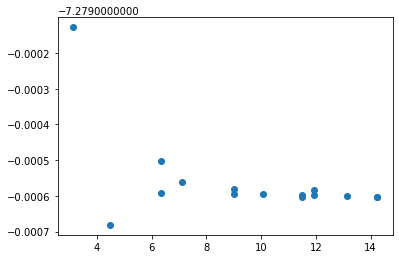

In [11]:
plt.scatter(x, y)

In [18]:
!pip install pybel

     |████████████████████████████████| 387 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 464 kB/s eta 0:00:01
     |████████████████████████████████| 101 kB 3.7 MB/s ta 0:00:01
     |████████████████████████████████| 96 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 153 kB 6.8 MB/s eta 0:00:01
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5908 sha256=d362d5bf13523d8d4fa5f248f0699a19037f9f1bf4da63a88d4cc58df1cbbcdd
  Stored in directory: /home/user/.cache/pip/wheels/14/1e/97/126009a0884bdf7e26436cace73d9a4f4596dada4fdc4950ce
Successfully built ratelimit


In [75]:
!conda install -c conda-forge rdkit

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/user/anaconda3/envs/bacc

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.3             |       h516909a_0         560 KB  conda-forge
    boost-1.74.0               |   py39h5472131_3         368 KB  conda-forge
    boost-cpp-1.74.0           |       h312852a_4        16.3 MB  conda-forge
    bzip2-1.0.8            

Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting.



In [76]:
1

1